In [ ]:
import nltk
>>> nltk.download()

## Exploring Linkedin Summaries using Topic Modeling


In [35]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib as matplot
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
import matplotlib
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [2]:
#Load the Google Data Scientist Linkedin Data
googleDatasci = pd.read_csv("Datasets/googledatasci.csv")

#Remove the first column
del googleDatasci['Unnamed: 0']

#Select only the rows with Google as company
googleDatasci = googleDatasci.loc[(googleDatasci.company == 'Google')]

#Remove any row that doesn't contain data scientist in the headline
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Technical Program Manager") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Supply chain & Operations leader") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("DevIntel on Developer Products") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("China Display Product Lead") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Sales Operations Senior") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("APM Intern") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Trust and Safety manager") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("User Growth, Google Play") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Ads Solutions Consultant") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Regional Customer Engineer") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Software Engineering Intern") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Product Manager") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Software Developer") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Software Engineer") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Software engineer") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Opportunity Seeker") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Student at University of Toronto") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Google Policy Fellow") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Science Advocate") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Engineer") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Account Manager Display") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Customer Engineering Manager") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Strategist") == False]
googleDatasci = googleDatasci[googleDatasci.headline.str.contains("Program Manager") == False]

#print out the dataset
#googleDatasci

In [3]:
#Select the summaries column to write a text file to build the initial corpus
googleDatasummary = googleDatasci['summary']

#Remove any unnecessary characters 
googleDatasci['summary'] = googleDatasci['summary'].replace(r'\t', '', regex=True) 
googleDatasci['summary'] = googleDatasci['summary'].replace(r'\n', ' ', regex=True) 
googleDatasci['summary'] = googleDatasci['summary'].replace(r'\...', ' ', regex=True)
googleDatasci['summary'] = googleDatasci['summary'].replace(r'\..', ' ', regex=True)
googleDatasci['summary'] = googleDatasci['summary'].replace('●', '', regex=True) 
googleDatasci['summary'] = googleDatasci['summary'].replace('•', '', regex=True)
googleDatasci['summary'] = googleDatasci['summary'].replace('-', '', regex=True) 
googleDatasci['summary'] = googleDatasci['summary'].replace('&', '', regex=True)
googleDatasci['summary'] = googleDatasci['summary'].replace('$', '', regex=True)
googleDatasci['summary'] = googleDatasci['summary'].replace(',', '', regex=True)


#googleDatasci = googleDatasci.translate(None, "(){}<>")

#
googleDatasci['summary'] = googleDatasci['summary'].str.lower()

#Remove any row with a NaN
googleDatasci['summary'] = googleDatasci['summary'].dropna()
googleDatasci = googleDatasci[googleDatasci.summary.str.contains("NaN") == False]


googleDatasci

#gs = googleDatasci['summary']

#googleSummary = pd.DataFrame(gs)
#googleSummary

name  \
1    Aaron Roan                   
2    Abhilasha S.                 
3    Abhilash Mittapalli          
5    Adam Kalman, Ph.D.           
6    Aditya Padala                
9    Adrish Sannyasi              
10   Ahmad Emad                   
18   Alex Chinien                 
27   Andres Lindner               
28   Angshuman Saha               
30   Anna Katrine Jørgensen       
34   Arik Motskin                 
36   Ashish Tendulkar             
39   Alexander Yakubovich         
41   Brian Bahmanyar              
46   Cathy Yuen Yi Lee            
56   Christian Howard             
59   Christopher Stewart, Ph.D.   
66   David Remus                  
69   Debidatta Dwibedi            
70   Richard Demsyn-Jones         
71   Detian Deng                  
72   Dhanur Balagere              
73   Diogo Moitinho de Almeida    
74   Doug Kelly                   
75   Dr. Saket Kumar              
79   Dustin McIntosh              
86   Ercan Yildiz                 
88   Erwin Huizenga               
89   Marc Ettlinger, Ph.D.        
..                     ...        
279  Shuchao B.                   
284  Sneha Chatterjee             
287  Steven Scherer               
289  Stoyan Georgiev              
290  Stuart Robinson              
291  Sjef van Stiphout            
300  Tom Ferriss                  
301  Tom Zahavy                   
302  Tong Wang                    
306  Valentine Fontama            
307  Valliappa Lakshmanan         
311  Kaushik Subramanian          
313  Jan Vlachy                   
314  Wan Chen                     
319  William Lane                 
320  Wynn Vonnegut                
321  Xia Li                       
323  Xiaofan Xu                   
325  Xiaojun Di                   
326  Xiaoli Yan                   
327  Xiaoxiao Wang                
328  Eric Li                      
332  Jackie (Rongjing) Xiang      
338  Yaohui Zeng                  
341  Yi Deng                      
342  Yipeng Yang                  
344  Yoann ASSAYAG                
347  Yue Shi                      
353  Zhenyu Lu                    
356  Zynab Ali                    

                                                                                                                                                                                                                                                                                                                                              certifications  \
1    Preventing Workplace Harassment                                                                                                                                                                                                                                                                                                                           
2    Python, SQL; Green Belt                                                                                                                                                                                                                                                                                                                                   
3    Programming in HTML5 with JavaScript and CSS3; Querying SQL server                                                                                                                                                                                                                                                                                        
5    Machine Learning; The Data Scientist's Toolbox; Mathematics Teacher, grades 7-12; AP Statistics Teacher                                                                                                                                                                                                                                                   
6    Kaggle R Tutorial on Machine Learning                                                      

In [17]:
from nltk.tokenize import WhitespaceTokenizer
ws_tokenizer = WhitespaceTokenizer()

article = googleDatasci['summary'][1]

# tokenize example document
nyt_ws_tokens = ws_tokenizer.tokenize(article.lower())

#print (nyt_ws_tokens)

import nltk
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['my','at', 'from', 'am']
stopwords.extend(newStopWords)

## Term Weighting using TF-IDF

In [19]:
with open('summary.txt', 'w') as out:
    for n in str(googleDatasci['summary']):
        out.write(n)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
stop_words = set(stopwords.words('english'))

raw_documents = []
snippets = []
with open("summary.txt","r") as fin:
    for line in fin.readlines():
        text = line.strip()
        raw_documents.append( text )
        # keep a short snippet of up to 100 characters as a title for each article
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 62 raw text documents


In [21]:
vectorizer = TfidfVectorizer(stop_words, max_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]))

Created 62 X 1537 TF-IDF-normalized document-term matrix


In [22]:
# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 1537 distinct terms


In [23]:
import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [26]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:80] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. my (2.28)
02. analysis (2.27)
03. statistical (2.08)
04. science (2.05)
05. modeling (2.01)
06. skills (1.89)
07. at (1.83)
08. google (1.62)
09. research (1.59)
10. from (1.51)
11. software (1.48)
12. models (1.48)
13. statistics (1.41)
14. development (1.39)
15. am (1.36)
16. years (1.35)
17. business (1.34)
18. have (1.33)
19. big (1.28)
20. python (1.24)
21. scientist (1.23)
22. as (1.23)
23. working (1.22)
24. analytics (1.22)
25. management (1.20)
26. products (1.20)
27. experienced (1.18)
28. language (1.17)
29. mining (1.16)
30. processing (1.16)
31. algorithms (1.15)
32. making (1.13)
33. product (1.08)
34. sql (1.06)
35. large (1.06)
36. demonstrated (1.03)
37. engineering (1.03)
38. using (1.01)
39. history (1.01)
40. computational (1.00)
41. that (0.99)
42. an (0.96)
43. programming (0.96)
44. sas (0.94)
45. bayesian (0.93)
46. mathematics (0.92)
47. decision (0.92)
48. building (0.91)
49. about (0.90)
50. knowledge (0.89)
51. industry (0.88)
52. problems (0.87)
53. met

## Initial Topic Modeling 

In [40]:
# Input parameter for the number of topics to make
k = 4

In [41]:
# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [42]:
#See the output of the model
W.shape

(62, 4)

In [43]:
# round to 2 decimal places for display purposes# round 
W[0,:].round(2)

array([ 0.13,  0.01,  0.13,  0.09])

In [44]:
#See the H factor
H.shape

(4, 1537)

In [45]:
#What is science associated with
term_index = terms.index('science')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([ 0.05,  0.12,  0.16,  0.11])

## Initial Topic Descriptors

In [46]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [47]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: modeling, analysis, statistical, bayesian, models, from, development, linear, programming, sas
Topic 02: language, natural, processing, questions, nlp, statistics, problems, other, mathematics, computational
Topic 03: demonstrated, history, impact, experienced, drive, 323, high, 284, power, manager
Topic 04: my, have, business, skills, at, management, or, that, mining, me


In [48]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

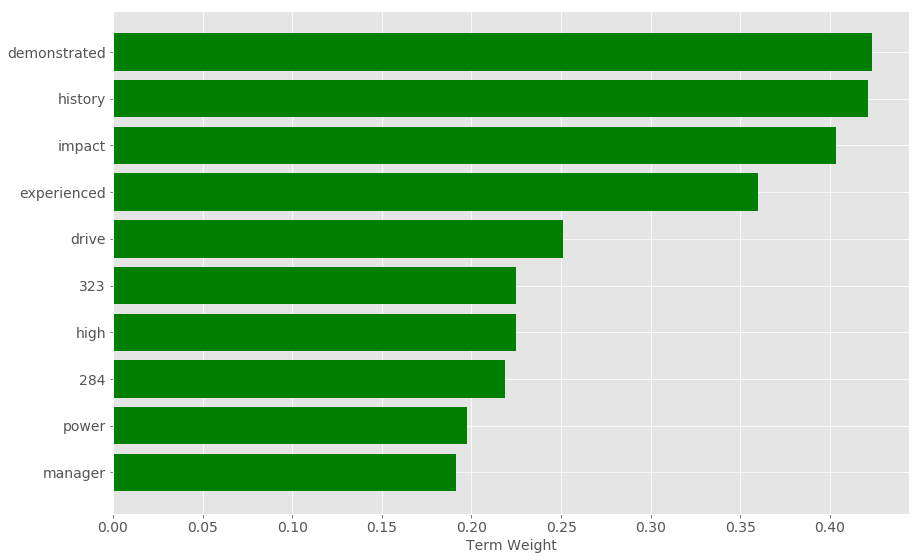

In [49]:
plot_top_term_weights( terms, H, 2, 10)

In [51]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets

In [55]:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. 5      i am passionate about data science machine learning natural language processing and other    
02. 59     i am an enthusiastic investigator of practical research questions related to people language 
03. 290    my goal is to continue working on problems related to semantic technology in general and natu
04. 30     experienced computational linguist with a demonstrated history of working in the internet ind
05. 344    master student in applied mathematics with processional experience in programing and data ana
06. 313    background in operations research statistics and applied mathematics ork experience in analyt
07. 41     statistics machine learning software engineering
08. 89     currently: leading a team making the google assistant a whole lot better across dozens of lan
09. 332    experienced researcher/software engineer in statistical machine learning and large scale data
10. 39     i am a data scientist deeply interested in in visualizing modelling and predicting human 

In [54]:
topic_snippets = get_top_snippets( snippets, W, 2, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. 284    experienced data scientist with a demonstrated history of leveraging big data to power machin
02. 323    experienced data science manager with a demonstrated history of building high impact data pro
03. 356    experienced data analyst with a demonstrated history of working in the information technology
04. 30     experienced computational linguist with a demonstrated history of working in the internet ind
05. 74     helping drive decision making at google cloud
06. 18     data science with a focus on e commerce and retail  media analytics and attribution  data sci
07. 307    enable customers of google cloud to be successful with our big data and machine learning prod
08. 1       data scientist dedicated to providing insights for social good and business strategy technol
09. 86     data scientist interested in building and leveraging a 360degree view of customers/users  am 
10. 56     experienced and creative science writer with expertise in delivering highly technical conten

In [57]:
from sklearn.externals import joblib
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k)

['articles-model-nmf-k04.pkl']